In [315]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pickle
import itertools
from datetime import datetime, timedelta
from tqdm.notebook import tqdm

from scipy import stats
import scipy.ndimage
import gc

from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve
from sklearn.metrics import classification_report, precision_recall_curve, f1_score, confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.pipeline import make_pipeline, make_union
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler

import dask.dataframe as dd
from dask.distributed import Client, LocalCluster

import catboost
from catboost import CatBoostClassifier, Pool, EShapCalcType, EFeaturesSelectionAlgorithm

import optuna
from optuna.samplers import TPESampler

np.set_printoptions(2)
np.random.seed(42)
gc.enable()

In [2]:
def reduce_memory(df, silent=False):
    def time_format(sec):
        return str(timedelta(seconds=sec))
    assert isinstance(df, dd.DataFrame), 'This is not a dask dataframe'
    start_t = time.time()
    
    if not silent:
        start_memory_usage = client.compute(df.memory_usage(deep=True).sum() / 1024**2)
        print('Start of dataframe memory optimization'.center(100,'*'))
        print(f'Memory usage by dataframe: {start_memory_usage.result():.02f} MB')
    
    df_dtype = pd.DataFrame(df.dtypes, columns=['dtype'], index = df.columns)
    
    df_min = client.compute(df.select_dtypes(['int', 'float']).min())
    df_max = client.compute(df.select_dtypes(['int', 'float']).max())
    df_is_int = client.compute(~(df.select_dtypes(['int', 'float']).fillna(0).astype(int).sum() - df.select_dtypes(['int', 'float']).fillna(0).sum()).astype('bool_'))
    
    df_dtype['min'] = df_min.result()
    df_dtype['max'] = df_max.result()
    df_dtype['is_int'] = df_is_int.result()
    
    df_dtype.loc[(df_dtype['is_int'] == True),'dtype'] = 'int64'
    df_dtype.loc[(df_dtype['is_int'] == True) & (df_dtype['min'] >= np.iinfo('int32').min) & (df_dtype['max'] <= np.iinfo('int32').max),'dtype'] = 'int32'
    df_dtype.loc[(df_dtype['is_int'] == True) & (df_dtype['min'] >= np.iinfo('int16').min) & (df_dtype['max'] <= np.iinfo('int16').max),'dtype'] = 'int16'
    df_dtype.loc[(df_dtype['is_int'] == True) & (df_dtype['min'] >= np.iinfo('int8').min) & (df_dtype['max'] <= np.iinfo('int8').max),'dtype'] = 'int8'
    
    df_dtype.loc[(df_dtype['is_int'] == True) & (df_dtype['min'] >= np.iinfo('uint64').min) ,'dtype'] = 'uint64'
    df_dtype.loc[(df_dtype['is_int'] == True) & (df_dtype['min'] >= np.iinfo('uint32').min) & (df_dtype['max'] <= np.iinfo('uint32').max),'dtype'] = 'uint32'
    df_dtype.loc[(df_dtype['is_int'] == True) & (df_dtype['min'] >= np.iinfo('uint16').min) & (df_dtype['max'] <= np.iinfo('uint16').max),'dtype'] = 'uint16'
    df_dtype.loc[(df_dtype['is_int'] == True) & (df_dtype['min'] >= np.iinfo('uint8').min) & (df_dtype['max'] <= np.iinfo('uint8').max),'dtype'] = 'uint8'
    
    df_dtype.loc[(df_dtype['is_int'] == True) & (df_dtype['min'] == 0) & (df_dtype['max'] == 1),'dtype'] = 'bool_'
    
    df_dtype.loc[(df_dtype['is_int'] == False), 'dtype'] = 'float64'
    df_dtype.loc[(df_dtype['is_int'] == False) & (df_dtype['min'] >= np.finfo('float32').min) & (df_dtype['max'] <= np.finfo('float32').max), 'dtype'] = 'float32'
    df_dtype.loc[(df_dtype['is_int'] == False) & (df_dtype['min'] >= np.finfo('float16').min) & (df_dtype['max'] <= np.finfo('float16').max), 'dtype'] = 'float16'
    
    for col in df.select_dtypes('object').columns:
        num_unique_values = client.compute(df[col].nunique())
        num_total_values = client.compute(df['id'].shape)
        if num_unique_values.result() / num_total_values[0].result() < 0.5:
            df_dtype.loc[col, 'dtype'] = 'category'
    
    dtypes = df_dtype['dtype'].to_dict()
    
    df = df.astype(dtypes)
    
    if not silent:
        memory_usage = client.compute(df.memory_usage(deep=True).sum() / 1024**2)
        print('MEMORY USAGE AFTER COMPLETION:'.center(40,'_'))
        print(f'Memory usage of properties dataframe is : {memory_usage.result():.02f} MB')
        print(f'This is {100*memory_usage.result()/start_memory_usage.result():.02f} % of the initial size')
        print(f'End of dataframe memory optimization, run time: {time_format(time.time()-start_t)}'.center(100,'*'))
    return df

In [4]:
if not os.path.exists('features.pkl'):
    cluster = LocalCluster(n_workers=4)
    client = Client(cluster)
    
    features = dd.read_csv('features.csv', sep='\t').drop('Unnamed: 0', axis=1)
    
    features = reduce_memory(features)
    features = features.set_index('id')

    features = features.compute()

    features.to_pickle('features.pkl')    

*******************************Start of dataframe memory optimization*******************************
Memory usage by dataframe: 8779.15 MB
_____MEMORY USAGE AFTER COMPLETION:_____
Memory usage of properties dataframe is : 2663.90 MB
This is 30.34 % of the initial size
*******************End of dataframe memory optimization, run time: 0:02:46.456361*******************


In [142]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            return X
        return X[self.columns]

In [288]:
train = pd.read_csv('data_train.csv').drop('Unnamed: 0', axis=1)
test = pd.read_csv('data_test.csv').drop('Unnamed: 0', axis=1)

In [183]:
train.target.value_counts(normalize=True)

0.0    0.927631
1.0    0.072369
Name: target, dtype: float64

In [289]:
features = pd.read_pickle('features.pkl').reset_index()
# features =  dd.from_pandas(features, npartitions=10)

In [185]:
# missing values
# outliers are not very important for boosting models
features.isnull().sum().sum() / features.count().sum()

0.0

In [290]:
# constant features
to_drop = []
for column in features.columns:
    unique = features[column].nunique()
    if unique == 1:
        to_drop.append(column)
        print(column)

75
81
85
139
203


**Dataset**

In [291]:
train['buy_time'] = train['buy_time'].astype(np.uint32)
train['id'] = train['id'].astype(np.uint64)
features = features.loc[(features['id'].isin(train['id'].unique()))]
features.drop(to_drop, axis=1, inplace=True)

train = train.sort_index()
train = train.sort_values(by='buy_time')
features = features.sort_values(by='buy_time')

In [292]:
data_train = pd.merge_asof(train, features, on='buy_time', by='id', direction='nearest')
del features, train

In [293]:
map_dict = {float(i): f'{i}' for i in range(100)}

In [294]:
data_train['date'] = pd.to_datetime(data_train['buy_time'], unit='s')

data_train['day'] = data_train['date'].dt.day
data_train['week'] = data_train['date'].dt.week
data_train['month'] = data_train['date'].dt.month
data_train['dayweek'] = data_train['date'].dt.weekday
# data_train['vas_id'] = data_train['vas_id'].map(map_dict).astype('category')
data_train.set_index('id', inplace=True)

data_train.drop('date', axis=1, inplace=True)

In [254]:
# data_train.to_csv('megadata.csv', index=False, encoding='utf-8', compression='zip')

In [295]:
X = data_train.drop(['target'], axis=1)
y = data_train['target']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, test_size=0.3, stratify=y, random_state=42)

del data_train, X, y

In [79]:
for col in X_train.select_dtypes('number').columns:
    factor_a, factor_b = X_train[col].sample(int(0.05*len(X_train))), X_valid[col].sample(int(0.05*len(X_valid)))
    _, pval = stats.shapiro(factor_a)
    if pval > 0.05:
        _, pval = stats.ttest_ind(factor_a, factor_b, equal_var=False)
    else:
        _, pval = stats.mannwhitneyu(factor_a, factor_b)
    if pval < 0.05:
        print(f'Different dist. in {col}, p-value: {pval:.4f}')

Different dist. in 5, p-value: 0.0041
Different dist. in 45, p-value: 0.0314
Different dist. in 53, p-value: 0.0413
Different dist. in 65, p-value: 0.0494
Different dist. in 84, p-value: 0.0266
Different dist. in 96, p-value: 0.0368
Different dist. in 101, p-value: 0.0216
Different dist. in 123, p-value: 0.0472
Different dist. in 163, p-value: 0.0041
Different dist. in 193, p-value: 0.0244
Different dist. in 227, p-value: 0.0282
Different dist. in 239, p-value: 0.0292


In [54]:
cat_cols = X_valid.select_dtypes('category').columns.tolist()  # set vas_id to category first

train_pool = Pool(X_train, y_train, cat_features=cat_cols)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_cols)

In [55]:
cat = CatBoostClassifier(task_type='GPU', iterations=300, auto_class_weights='SqrtBalanced', silent=True).fit(train_pool)
# number of iterations was chosen from train-valid catboost plot

In [56]:
train_preds = catboost.CatBoost.predict(cat, train_pool, prediction_type='Class')
valid_preds = catboost.CatBoost.predict(cat, valid_pool, prediction_type='Class')

print(classification_report(y_train, train_preds, digits=4))
print(classification_report(y_valid, valid_preds, digits=4))

              precision    recall  f1-score   support

         0.0     0.9815    0.9222    0.9510    540027
         1.0     0.4383    0.7777    0.5606     42130

    accuracy                         0.9118    582157
   macro avg     0.7099    0.8500    0.7558    582157
weighted avg     0.9422    0.9118    0.9227    582157

              precision    recall  f1-score   support

         0.0     0.9808    0.9222    0.9506    231440
         1.0     0.4354    0.7688    0.5559     18056

    accuracy                         0.9111    249496
   macro avg     0.7081    0.8455    0.7533    249496
weighted avg     0.9413    0.9111    0.9220    249496



In [105]:
y_train.value_counts(normalize=True)

0.0    0.927631
1.0    0.072369
Name: target, dtype: float64

In [108]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum()

(0, 0)

**There are multiple ways to search and deal with outliers. Most common:**
* statisctical
    * Z-score: check if data lies between 2-3 $\sigma$, assuming data follows normal distribution
    * IQR score, where outliers fall out this region: $Q_1 - 1.5\cdot (Q_3 - Q_1)< X_i < Q_3 + 1.5\cdot (Q_3 - Q_1)$
* visual
    * scatterplots
    * boxplots (graphical representation of IQR)
* using ML models
    * IsolationForest: $outlier_{index} = -1$
    * DBSCAN clustering: $X_i > \epsilon$

**What to do?**
* drop outliers if there few of them
* replace by some statistical value (median, mode), some other insight
* impute with ML model, e.g. sklearn IterativeImputer
* define new binary (not neccessary binary) feature to indicate objects with outliers

**CatBoost**

Gradient Boosting models are not very sensitive to outliers, also it is computationally expensive to search and deal with ones here. The decision is to let it be as is.

#### Some statistical tests

In [149]:
sample_size = int(0.001*len(X_train))
imp = []
counter = 0
y_train.index = X_train.index
for col in X_train.select_dtypes('number').columns:
    factor_a = X_train.loc[y_train == 0, col].sample(sample_size)
    factor_b =  X_train.loc[y_train == 1, col].sample(sample_size)
    _, pval = stats.shapiro(factor_a)
    if pval > 0.05:
        _, pval = stats.ttest_ind(factor_a, factor_b, equal_var=False)
    else:
        _, pval = stats.mannwhitneyu(factor_a, factor_b)
    if pval >= 0.05:
        counter += 1
    else:
        imp.append(col)
print(f'Number of statitically unimportant numerical columns: {counter}')
print(f'Number of features that have statistical impact on target variable: {len(imp)}.')

Number of statitically unimportant numerical columns: 216
Number of features that have statistical impact on target variable: 36.


#### Attempt to make numerical columns more informative (Feature Engineering)

In [156]:
# X = pd.concat([X_fold, X_test], axis=0)
# y = pd.concat([y_fold, y_test], axis=0)
# y.index = X.index

df_test = X[X.columns[1:249].tolist()].values

unique_samples = []
unique_count = np.zeros_like(df_test)
for feature in range(df_test.shape[1]):
    _, index_, count_ = np.unique(df_test[:, feature], return_counts=True, return_index=True)
    unique_count[index_[count_ == 1], feature] += 1

real_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) > 0)[:, 0]
synthetic_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) == 0)[:, 0]

print(len(real_samples_indexes))
print(len(synthetic_samples_indexes))

748465
83188


In [19]:
pca_columns = X_train.columns[1:249].tolist()

#scaler = StandardScaler()
#pca = PCA(n_components=None, random_state=42).fit(scaler.fit_transform(X_train[pca_columns]))

In [170]:
total = np.sum(pca.explained_variance_)
pca.explained_variance_[:185].sum() / total

0.9914872861190183

In [20]:
non_pca_columns = [X_train.columns[0]] + X_train.columns[249:].tolist()
len(pca_columns) + len(non_pca_columns) == X_train.shape[1]

True

In [45]:
pca_pipe = make_pipeline(StandardScaler(), PCA(n_components=110, random_state=42))

In [46]:
X_train_pca = pca_pipe.fit_transform(X_train[pca_columns])
X_train_pca = np.concatenate([X_train[non_pca_columns[1:]].values, X_train_pca], axis=1).astype(np.float32)
X_train_pca = pd.DataFrame(data=X_train_pca, index=X_train.index)
X_train_pca['vas_id'] = X_train['vas_id'].copy()

In [47]:
X_valid_pca = pca_pipe.transform(X_valid[pca_columns])
X_valid_pca = np.concatenate([X_valid[non_pca_columns[1:]].values, X_valid_pca], axis=1).astype(np.float32)
X_valid_pca = pd.DataFrame(data=X_valid_pca, index=X_valid.index)
X_valid_pca['vas_id'] = X_valid['vas_id'].copy()

In [48]:
cat_cols = X_valid.select_dtypes('category').columns.tolist()

train_pool = Pool(X_train_pca, y_train, cat_features=cat_cols)
valid_pool = Pool(X_valid_pca, y_valid, cat_features=cat_cols)

In [49]:
cat = CatBoostClassifier(task_type='GPU', auto_class_weights='SqrtBalanced', silent=True).fit(train_pool, eval_set=valid_pool)

In [56]:
cat.get_all_params()

{'nan_mode': 'Min',
 'gpu_ram_part': 0.95,
 'eval_metric': 'Logloss',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'FeatureFreq:CtrBorderCount=15:CtrBorderType=Median:Prior=0/1'],
 'iterations': 1000,
 'fold_permutation_block': 64,
 'leaf_estimation_method': 'Newton',
 'observations_to_bootstrap': 'TestOnly',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'boosting_type': 'Plain',
 'ctr_history_unit': 'Sample',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'devices': '-1',
 'pinned_memory_bytes': '104857600',
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'gpu_cat_features_storage': 'GpuRam',
 'fold_size_loss_normalization': False,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCo

In [50]:
train_preds = catboost.CatBoost.predict(cat, train_pool, prediction_type='Class')
valid_preds = catboost.CatBoost.predict(cat, valid_pool, prediction_type='Class')

print(classification_report(y_train, train_preds, digits=4))
print(classification_report(y_valid, valid_preds, digits=4))

              precision    recall  f1-score   support

         0.0     0.9816    0.9211    0.9504    540027
         1.0     0.4352    0.7792    0.5585     42130

    accuracy                         0.9108    582157
   macro avg     0.7084    0.8502    0.7545    582157
weighted avg     0.9421    0.9108    0.9221    582157

              precision    recall  f1-score   support

         0.0     0.9810    0.9211    0.9501    231440
         1.0     0.4328    0.7716    0.5546     18056

    accuracy                         0.9103    249496
   macro avg     0.7069    0.8464    0.7523    249496
weighted avg     0.9413    0.9103    0.9215    249496



**with n_components=185 we got small decrease in metrics, but calculations became much faster due to dimensionality reduction**

In [353]:
sigma_fac = 0.001
sigma_base = 4
features = X_train.columns.tolist()[1:-4]
eps = 1e-10

def get_count(X, features):
    features_count = np.zeros((X.shape[0], len(features)))
    features_density = np.zeros((X.shape[0], len(features)))
    features_deviation = np.zeros((X.shape[0], len(features)))
    
    X_index = X.index
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    X = pd.DataFrame(data=X, columns=features, index=X_index)
    
    sigmas = []

    for i,var in enumerate(tqdm(features)):
        X_var_int = (X[var].values * 1000000).round().astype(int)

        lo = X_var_int.min()
        X_var_int -= lo

        hi = X_var_int.max()+1
        counts_all = np.bincount(X_var_int, minlength=hi).astype(float)
        # counts_all = np.histogram(X_var_int, bins=hi)[0].astype(float)
        zeros = (counts_all == 0).astype(int)
        before_zeros = np.concatenate([zeros[1:],[0]])
        indices_all = np.arange(counts_all.shape[0])

        sigma_scaled = counts_all.shape[0]*sigma_fac
        sigma = np.power(sigma_base * sigma_base * sigma_scaled, 1/3)
        sigmas.append(sigma)
        counts_all_smooth = scipy.ndimage.filters.gaussian_filter1d(counts_all, sigma)
        deviation = counts_all / (counts_all_smooth+eps)
        indices = X_var_int
        features_count[:,i] = counts_all[indices]
        features_density[:,i] = counts_all_smooth[indices]
        features_deviation[:,i] = deviation[indices]
        
    features_count_names = [var+'_count' for var in features]
    features_density_names = [var+'_density' for var in features]
    features_deviation_names = [var+'_deviation' for var in features]
    X_count = pd.DataFrame(columns=features_count_names, data = features_count)
    X_count.index = X.index
    X_density = pd.DataFrame(columns=features_density_names, data = features_density)
    X_density.index = X.index
    X_deviation = pd.DataFrame(columns=features_deviation_names, data = features_deviation)
    X_deviation.index = X.index
    X = pd.concat([X, X_count, X_density, X_deviation], axis=1)   
    
    del X_count, X_density, X_deviation
    del features_count_names, features_density_names, features_deviation_names
    
    return X

In [20]:
X_train_index = X_train.index
X_valid_index = X_valid.index

X = pd.concat([X_train, X_valid], axis=0)

In [ ]:
del X_train_pca, X_valid_pca, train_pool, valid_pool

In [ ]:
# X = get_count(X[features])  # not enough memory to finish calculations of new features!

**CatBoost Feature Selection**
    
   * sklearn SelectFromModel, based on feature_importancies, the most important - most frequently used in node splits
   * BorutaShap - great feature selector, based on statistical tests and shap values (slow for current task)
   * CatBoost select_features, based on couple of approaches. The one is used here is Recursive algorithm with shap-values

In [55]:
def select_features(algorithm: EFeaturesSelectionAlgorithm, steps: int = 1):
    print('Algorithm:', algorithm)
    model = CatBoostClassifier(iterations=1000, 
                               task_type='GPU', 
                               auto_class_weights='SqrtBalanced', 
                               allow_writing_files=False,
                               eval_metric='TotalF1:average=Macro',
                               random_seed=42)
    summary = model.select_features(
                                    train_pool,
                                    eval_set=valid_pool,
                                    features_for_select=list(range(X_train.shape[1])),
                                    num_features_to_select=210,
                                    steps=steps,
                                    algorithm=algorithm,
                                    shap_calc_type=EShapCalcType.Exact,
                                    train_final_model=True,
                                    logging_level='Silent',
                                    plot=True
    )
    print('Eliminated features:', summary['eliminated_features_names'])
    return summary

feature_set = select_features(algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, steps=10)

Algorithm: EFeaturesSelectionAlgorithm.RecursiveByShapValues


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Eliminated features: ['43', '128', '223', '115', '241', '186', '247', '111', '6', '171', '188', '136', '243', '21', '116', '2', '112', '169', '191', '0', '61', '124', '50', '45', '42', '63', '7', '52', '60', '11', '62', '68', '13', '148', '251', '190', '194', '133', '164', '49', '4', '233', '106']


In [59]:
X_train_sel = X_train.drop(feature_set['eliminated_features_names'], axis=1)
X_valid_sel = X_valid.drop(feature_set['eliminated_features_names'], axis=1)

cat_cols = X_valid_sel.select_dtypes('category').columns.tolist()

train_pool = Pool(X_train_sel, y_train, cat_features=cat_cols)
valid_pool = Pool(X_valid_sel, y_valid, cat_features=cat_cols)

cat = CatBoostClassifier(task_type='GPU', 
                         auto_class_weights='SqrtBalanced',
                         allow_writing_files=False,
                         # eval_metric='TotalF1:average=Macro',
                         # random_seed=42,
                         silent=True
                                    ).fit(train_pool, eval_set=valid_pool)

train_preds = catboost.CatBoost.predict(cat, train_pool, prediction_type='Class')
valid_preds = catboost.CatBoost.predict(cat, valid_pool, prediction_type='Class')

print(classification_report(y_train, train_preds, digits=4))
print(classification_report(y_valid, valid_preds, digits=4))

              precision    recall  f1-score   support

         0.0     0.9817    0.9213    0.9506    540027
         1.0     0.4362    0.7802    0.5596     42130

    accuracy                         0.9111    582157
   macro avg     0.7090    0.8508    0.7551    582157
weighted avg     0.9423    0.9111    0.9223    582157

              precision    recall  f1-score   support

         0.0     0.9809    0.9213    0.9502    231440
         1.0     0.4331    0.7707    0.5545     18056

    accuracy                         0.9104    249496
   macro avg     0.7070    0.8460    0.7524    249496
weighted avg     0.9413    0.9104    0.9216    249496



In [60]:
del X_train_sel, X_valid_sel

**Dealing with imbalanced classes**
* over_sampling - add copies of samples in minority class in train data: model will overfit (RandomOverSampler)
* under_sampling - remove majority class samples from train data: loose a lot of useful information (RandomUnderSampler)
* generating - generate new minority samples, that have close distance to real (SMOTE and it's derivatives)
* combining - generate new minority samples and remove some near-classborder samples (SMOTEENN, SMOTETomek)
* class_weights - strike the model more if it makes error on minority class (in tree leaves)

We will apply class_weights as it is rather powerfull method. Besides all generating and oversampling methods is quite often leed to overfitting. It is also mentioned by computational issues (more samples - more memory required). As for undersampling - we don't want to loose information about users. 

**Usefull functions to report and visualize**

In [317]:
# report
def report(y_train, y_train_pred, y_test, y_test_pred, y_train_proba=None, y_test_proba=None):
    print('Train\n', classification_report(y_train, y_train_pred, digits=4))
    print('Test\n', classification_report(y_test, y_test_pred, digits=4))
    if y_train_proba is not None and y_test_proba is not None:
        roc_train, roc_test = roc_auc_score(y_train, y_train_proba), roc_auc_score(y_test, y_test_proba)
        print(f'Train ROC_AUC: {roc_train:.3f}, Test ROC_AUC: {roc_test:.3f}')

# confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=4)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    # print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plot_roc_curve(fpr, tpr, model_name="", color=None):
    plt.plot(fpr, tpr, label='%s: ROC curve (area = %0.2f)' %
             (model_name, auc(fpr, tpr)), color=color)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s: Receiver operating characteristic curve' % model_name)
    plt.legend(loc="lower right")
    
def plot_precision_recall_curve(recall, precision, model_name="", color=None):
    plt.plot(recall, precision, label='%s: Precision-Recall curve (area = %0.2f)' %
             (model_name, auc(recall, precision)), color=color)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("%s: Precision-Recall curve" % model_name)
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.legend(loc="lower left")

# calibration probs
def get_best_threshold(y_true, y_score):
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    fscore = 2 * precision * recall / (precision + recall)
    ix = np.argmax(fscore)
    score_macro = f1_score(y_true, y_score >= thresholds[ix], average='macro')
    return thresholds[ix], fscore[ix], score_macro

**Optuna Hyperparameters Search**

In [107]:
# optuna
start_params = {
                'iterations': 2000,
                'silent': True,
                'one_hot_max_size': 2,
                'use_best_model': True,
                'early_stopping_rounds': 100,
                'allow_writing_files': False,
                'random_seed': 42,
                'grow_policy': 'Lossguide', # SymmetricTree
                'boosting_type': 'Plain',
                'eval_metric': 'TotalF1:average=Macro',
                'auto_class_weights': 'SqrtBalanced',
                'task_type': 'GPU',
}

In [108]:
def objective(trial):
    param_trials = {
                    'depth': trial.suggest_int('depth', 3, 10),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
                    'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 2., 8.),
                    'bagging_temperature': trial.suggest_float('bagging_temperature', 1., 5.),
                    # 'subsample': trial.suggest_float('subsample', 0.5, 1.), # Bayesian bootstrap dont match (use Bernuolli)
                    # 'rsm': trial.suggest_float('colsample_bylevel', 0.3, 1.), # CPU-only
                    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 255),
                    'max_leaves': trial.suggest_int('max_leaves', 5, 250), # Lossguide-only
                    }
    
    param_trials.update(start_params)
    
    opt_model = CatBoostClassifier(**param_trials)
    opt_model.fit(train_pool, eval_set=valid_pool)
    
    y_pred = catboost.CatBoost.predict(opt_model, valid_pool, prediction_type='Class')
    score = f1_score(y_valid, y_pred, average='macro')
    
    return score

In [ ]:
optuna.logging.set_verbosity(optuna.logging.INFO)
study = optuna.create_study(sampler=TPESampler(seed=42), direction="maximize")
study.optimize(objective, n_trials=100, timeout=3000)

print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
for key, value in trial.params.items():
    print(f'{key}: {value}')

In [57]:
boost_params = {
                'iterations': 2000,
                'silent': True,
                'one_hot_max_size': 2,
                'use_best_model': True,
                'early_stopping_rounds': 100,
                'allow_writing_files': False,
                'random_seed': 42,
                'grow_policy': 'Lossguide', # SymmetricTree
                'boosting_type': 'Plain', 
                'eval_metric': 'TotalF1:average=Macro',
                'auto_class_weights': 'SqrtBalanced',
                'task_type': 'GPU',
                # 'depth': 5,
                # 'learning_rate': 0.40299504119267027,
                # 'l2_leaf_reg': 2.9735248449224065,
                # 'bagging_temperature': 2.319686325124222,
                # 'min_data_in_leaf': 193
                'depth': 10,
                'learning_rate': 0.020830638552117038,
                'l2_leaf_reg': 7.154375575436655,
                'bagging_temperature': 1.0066114188862378,
                'min_data_in_leaf': 41,
                'max_leaves': 190
}

In [58]:
cat = CatBoostClassifier(**boost_params).fit(train_pool, eval_set=valid_pool)

train_preds = catboost.CatBoost.predict(cat, train_pool, prediction_type='Class')
valid_preds = catboost.CatBoost.predict(cat, valid_pool, prediction_type='Class')

report(y_train, train_preds, y_valid, valid_preds)

Train
               precision    recall  f1-score   support

         0.0     0.9823    0.9290    0.9549    540027
         1.0     0.4635    0.7858    0.5831     42130

    accuracy                         0.9187    582157
   macro avg     0.7229    0.8574    0.7690    582157
weighted avg     0.9448    0.9187    0.9280    582157

Test
               precision    recall  f1-score   support

         0.0     0.9797    0.9261    0.9522    231440
         1.0     0.4433    0.7543    0.5584     18056

    accuracy                         0.9137    249496
   macro avg     0.7115    0.8402    0.7553    249496
weighted avg     0.9409    0.9137    0.9237    249496



In [59]:
valid_probs = catboost.CatBoost.predict(cat, valid_pool, prediction_type='Probability')[:,1]

thres, fscore, fmacro = get_best_threshold(y_valid, valid_probs)
print(f'Best thres: {thres:.4f}, f1-score: {fscore:.4f}, fmacro: {fmacro:.4f}')

Best thres: 0.5398, f1-score: 0.5598, fmacro: 0.7574


Confusion matrix, without normalization


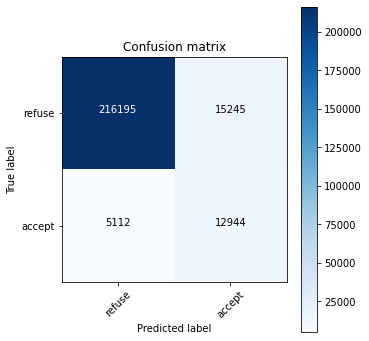

In [24]:
cnf_matrix = confusion_matrix(y_valid, valid_probs>=thres)
plt.figure(figsize=(5, 5))
plot_confusion_matrix(cnf_matrix, classes=['refuse', 'accept'], normalize=False,
                      title='Confusion matrix',)
plt.show()

**StratifiedKFold evaluation**

In [296]:
X = pd.concat([X_train, X_valid], axis=0)
y = pd.concat([y_train, y_valid], axis=0)
assert len(X) == len(y)

X_fold, X_test, y_fold, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)
del X, y

In [61]:
%%time

skf = StratifiedKFold(n_splits=3)
models = []

for train_index, valid_index in skf.split(X_fold, y_fold):
    X_train, X_valid = X_fold.iloc[train_index, :], X_fold.iloc[valid_index, :]
    y_train, y_valid = y_fold.iloc[train_index], y_fold.iloc[valid_index]
    
    train_pool = Pool(X_train, y_train, cat_features=cat_cols)
    valid_pool = Pool(X_valid, y_valid, cat_features=cat_cols)
    
    cat = CatBoostClassifier(**boost_params).fit(train_pool, eval_set=valid_pool)
    
    test_labels = cat.predict(X_test)
    print(classification_report(y_test, test_labels, digits=4), '\n', '='*30)
    
    models.append(cat)

              precision    recall  f1-score   support

         0.0     0.9797    0.9253    0.9517    154294
         1.0     0.4406    0.7543    0.5563     12037

    accuracy                         0.9129    166331
   macro avg     0.7101    0.8398    0.7540    166331
weighted avg     0.9407    0.9129    0.9231    166331
 
              precision    recall  f1-score   support

         0.0     0.9797    0.9257    0.9519    154294
         1.0     0.4417    0.7540    0.5571     12037

    accuracy                         0.9132    166331
   macro avg     0.7107    0.8398    0.7545    166331
weighted avg     0.9408    0.9132    0.9233    166331
 
              precision    recall  f1-score   support

         0.0     0.9796    0.9264    0.9523    154294
         1.0     0.4441    0.7533    0.5588     12037

    accuracy                         0.9139    166331
   macro avg     0.7119    0.8398    0.7555    166331
weighted avg     0.9409    0.9139    0.9238    166331
 
CPU times: total

In [62]:
cat = models[-1]
del models
# cat.save_model('cat', format='cbm', pool=train_pool)

In [63]:
test_probs = catboost.CatBoost.predict(cat, X_test, prediction_type='Probability')[:,1]

thres, fscore, fmacro = get_best_threshold(y_test, test_probs)
print(f'Best thres: {thres:.4f}, f1-score: {fscore:.4f}, fmacro: {fmacro:.4f}')

Best thres: 0.5268, f1-score: 0.5642, fmacro: 0.7601


Confusion matrix, without normalization


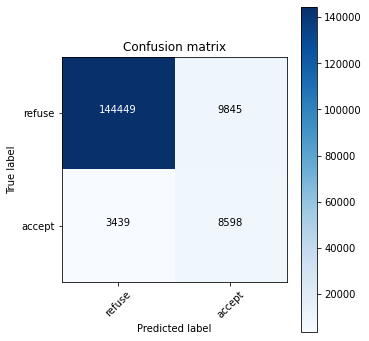

In [29]:
cnf_matrix = confusion_matrix(y_test, test_probs>=thres)
plt.figure(figsize=(5, 5))
plot_confusion_matrix(cnf_matrix, classes=['refuse', 'accept'], normalize=False,
                      title='Confusion matrix',)
plt.show()

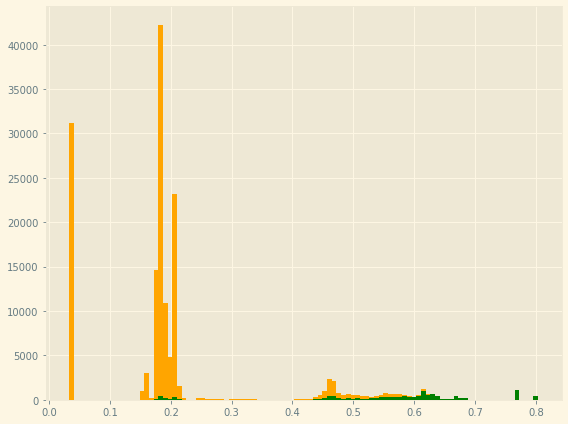

In [30]:
plt.style.use('Solarize_Light2')
plt.figure(figsize=(8,6))
plt.hist(test_probs[y_test == 0], bins=100, color='orange')
plt.hist(test_probs[y_test == 1], bins=100, color='green')
plt.tight_layout()
plt.show()

**Full dataset**

In [297]:
X = pd.concat([X_fold, X_test], axis=0)
y = pd.concat([y_fold, y_test], axis=0)
assert len(X) == len(y)

del X_fold, X_test, y_fold, y_test

In [65]:
total_params = {
                'iterations': 500,
                'silent': True,
                'one_hot_max_size': 2,
                'allow_writing_files': False,
                'random_seed': 42,
                'auto_class_weights': 'SqrtBalanced',
                'task_type': 'GPU',
}

In [66]:
%%time

skf = StratifiedKFold(n_splits=5)
scores = []

for i, (train_index, valid_index) in enumerate(skf.split(X, y), 1):
    X_train, X_test = X.iloc[train_index, :], X.iloc[valid_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[valid_index]
    
    train_pool = Pool(X_train, y_train, cat_features=cat_cols)
    test_pool = Pool(X_test, y_test, cat_features=cat_cols)
    
    cat = CatBoostClassifier(**total_params).fit(train_pool)
    
    labels = catboost.CatBoost.predict(cat, test_pool, prediction_type='Class')
    score = f1_score(y_test, labels, average='macro')
    print(f'{i}-fold score = {score:.4f}')
    
    scores.append(score)
    
print(f'Точность перекретсной оценки: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

1-fold score = 0.7503
2-fold score = 0.7535
3-fold score = 0.7537
4-fold score = 0.7535
5-fold score = 0.7525
Точность перекретсной оценки: 0.7527 +/- 0.0013
CPU times: total: 4min 13s
Wall time: 3min 19s


In [299]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=166330, stratify=y, random_state=42)
train_pool = Pool(X_train, y_train, cat_features=None)  # cat_cols, None if vas_id - ordinal

del X, y

In [301]:
test_pool = Pool(X_test, y_test, cat_features=None) # cat_cols, None if vas_id - ordinal

def select_features(algorithm: EFeaturesSelectionAlgorithm, steps: int = 1):
    print('Algorithm:', algorithm)
    model = CatBoostClassifier(eval_metric='TotalF1:average=Macro', 
                               **total_params)
    summary = model.select_features(
                                    train_pool,
                                    eval_set=test_pool,
                                    features_for_select=list(range(X_train.shape[1])),
                                    num_features_to_select=5,
                                    steps=steps,
                                    algorithm=algorithm,
                                    shap_calc_type=EShapCalcType.Exact,
                                    train_final_model=True,
                                    logging_level='Silent',
                                    plot=True
    )
    print('Eliminated features:', summary['eliminated_features_names'])
    return summary

feature_set = select_features(algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, steps=30)
del test_pool

Algorithm: EFeaturesSelectionAlgorithm.RecursiveByShapValues


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Eliminated features: ['39', '145', '1', '59', '167', '169', '66', '140', '141', '63', '38', '114', '146', '213', '53', '247', '97', '233', '127', '240', '58', '71', '105', '143', '136', '40', '187', '60', '150', '230', '51', '3', '112', '166', '25', '64', '228', '61', '246', '160', '236', '68', '248', '113', '115', '210', '5', '241', '10', '77', '50', '234', '111', '135', '245', '52', '138', '164', '191', '2', '171', '226', '250', '18', '47', '49', '148', '109', '165', '190', '116', '208', '238', '55', '124', '189', '130', '0', '107', '36', '102', '82', '147', '137', '129', '20', '108', '151', '239', '4', '243', '142', '211', '229', '128', '37', '8', '156', '117', '181', '163', '237', '93', '222', '73', '185', '209', '103', '172', '14', '106', '242', '182', '231', '42', '161', '70', '9', '62', '92', '54', '48', '11', '76', '125', '194', '43', '27', '131', '34', '192', '44', '19', '159', '244', '174', '249', '200', '126', '170', '188', '162', '101', '21', '168', '144', '22', '184', '28'

In [339]:
losses = feature_set['loss_graph'].get('loss_values')
names = feature_set['eliminated_features_names']

eliminated_features = [names[i] for i in range(len(names) - 1) if losses[i+1] - losses[i] < 0]

In [304]:
print(*eliminated_features, sep=', ')
print(f'\nNumber of eliminated features: {len(eliminated_features)}/{X_train.shape[1]}')

39, 145, 1, 59, 167, 169, 66, 140, 141, 63, 38, 114, 146, 213, 53, 247, 97, 233, 127, 240, 58, 71, 105, 143, 136, 40, 187, 60, 150, 230, 51, 3, 112, 166, 25, 64, 228, 61, 246, 160, 236, 68, 248, 113, 115, 210, 5, 241, 10, 77, 50, 234, 111, 135, 245, 52, 138, 164, 191, 2, 171, 226, 250, 18, 47, 49, 148, 109, 165, 190, 116, 208, 238, 55, 124, 189, 130, 0, 107, 36, 102, 82, 147, 11, 76, 125, 194, 43, 27, 131, 34, 192, 44, 19, 159, 244, 174, 249, 200, 126, 170, 188, 162, 101, 21, 168, 144, 22, 184, 28, 183, 227, 13, 223, 100, 251, 158, 7, 110, 69, 41, 149, 118, 65, 56, 176, 104, 235, 232, 123, 91, 119, 201, 31, 217, 90, 57, 96, 80, 252, 29, 173, 215, 94, 45, 206, 72, 79, 67, 98, 84, 225, 157, 186, 121, 133, 120, 204, 122, 155, 6, 99, 195, 198, 83, 78, 180, 86, 221, 16, 132, 214, 177, 88, 178, 154, 216, 175, 220, 23, 24, 95, 218, 35, 197

Number of eliminated features: 185/254


**Use features, selected by CatShap-values**

In [306]:
cat_cols_ = [col for col in cat_cols if col not in eliminated_features]
train_pool_ = Pool(X_train.drop(eliminated_features, axis=1), y_train, cat_features=None) # cat_cols, None if vas_id - ordinal
X_test_ = X_test.drop(eliminated_features, axis=1)

In [307]:
# features, dropped by shap-values
cat_ = CatBoostClassifier(**total_params).fit(train_pool_)

test_probs_ = catboost.CatBoost.predict(cat_, X_test_, prediction_type='Probability')[:, 1]
train_preds_ = catboost.CatBoost.predict(cat_, train_pool_, prediction_type='Class')
test_preds_ = catboost.CatBoost.predict(cat_, X_test_, prediction_type='Class')

report(y_train, train_preds_, y_test, test_preds_)

thres, fscore, fmacro = get_best_threshold(y_test, test_probs_)
print(f'Best thres: {thres}, f1-score: {fscore:.4f}, fmacro: {fmacro:.4f}')

Train
               precision    recall  f1-score   support

         0.0     0.9810    0.9231    0.9512    617174
         1.0     0.4388    0.7711    0.5593     48149

    accuracy                         0.9121    665323
   macro avg     0.7099    0.8471    0.7552    665323
weighted avg     0.9418    0.9121    0.9228    665323

Test
               precision    recall  f1-score   support

         0.0     0.9812    0.9232    0.9513    154293
         1.0     0.4399    0.7733    0.5608     12037

    accuracy                         0.9123    166330
   macro avg     0.7105    0.8482    0.7560    166330
weighted avg     0.9420    0.9123    0.9230    166330

Best thres: 0.562386481759898, f1-score: 0.5680, fmacro: 0.7623


In [308]:
cat_.save_model('cat_reduced')

AUC_ROC = 0.933


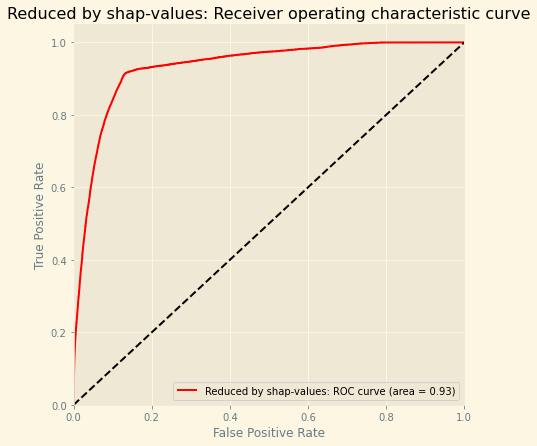

In [318]:
fpr, tpr, roc_thresholds = roc_curve(y_test, test_probs_)
precision, recall, pr_thresholds = precision_recall_curve(y_test, test_probs_)

plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "Reduced by shap-values", color='r')
print("AUC_ROC = %.3f" % auc(fpr, tpr))

AUC_PR = 0.569


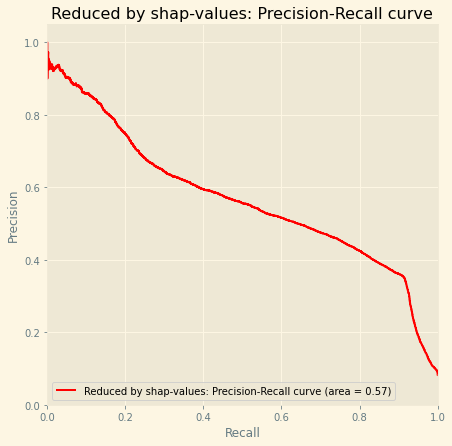

In [319]:
plt.figure(figsize=(7, 7))
    
plot_precision_recall_curve(recall, precision, "Reduced by shap-values", color='r')
print("AUC_PR = %.3f" % auc(recall, precision))

**Use features, selected by LogisticRegression with L1 penalty**

In [175]:
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

numerical = X_train.columns[2:-4].tolist()
other = [col for col in X_train.columns if col not in numerical]

estimator = make_pipeline(ColumnSelector(numerical),
                          MinMaxScaler(),
                          # PowerTransformer(method='yeo-johnson', standardize=False),
                          LogisticRegression(penalty='l1', solver='saga', C=0.01, 
                                             class_weight='balanced', random_state=42, n_jobs=-1)).fit(X_train, y_train)

In [358]:
union = make_union(make_pipeline(ColumnSelector(numerical),
                                 SelectFromModel(estimator=estimator[-1], prefit=True, threshold=1e-5)),
                   ColumnSelector(other), n_jobs=-1)

X_train_ = union.transform(X_train)
X_test_ = union.transform(X_test)

In [359]:
X_train_ = X_train_.astype(np.float32)
X_test_ = X_test_.astype(np.float32)

In [178]:
# features, dropped by SelectFromModel
cat__ = CatBoostClassifier(**total_params).fit(X_train_, y_train)

test_probs__ = catboost.CatBoost.predict(cat__, X_test_, prediction_type='Probability')[:, 1]
train_preds__ = catboost.CatBoost.predict(cat__, X_train_, prediction_type='Class')
test_preds__ = catboost.CatBoost.predict(cat__, X_test_, prediction_type='Class')

report(y_train, train_preds__, y_test, test_preds__)

thres, fscore, fmacro = get_best_threshold(y_test, test_probs__)
print(f'Best thres: {thres}, f1-score: {fscore:.4f}, fmacro: {fmacro:.4f}')

Train
               precision    recall  f1-score   support

         0.0     0.9811    0.9231    0.9512    617174
         1.0     0.4393    0.7719    0.5599     48149

    accuracy                         0.9122    665323
   macro avg     0.7102    0.8475    0.7556    665323
weighted avg     0.9419    0.9122    0.9229    665323

Test
               precision    recall  f1-score   support

         0.0     0.9811    0.9232    0.9513    154293
         1.0     0.4398    0.7724    0.5605     12037

    accuracy                         0.9123    166330
   macro avg     0.7105    0.8478    0.7559    166330
weighted avg     0.9420    0.9123    0.9230    166330

Best thres: 0.5754577266802828, f1-score: 0.5683, fmacro: 0.7630


In [380]:
eliminated_features = np.array(numerical)[estimator[-1].coef_[0] == 0].tolist()
np.array(numerical)[estimator[-1].coef_[0] == 0], other

(array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
        '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
        '24', '25', '27', '28', '29', '30', '31', '32', '33', '34', '35',
        '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46',
        '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57',
        '58', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71',
        '72', '73', '74', '76', '77', '78', '79', '80', '82', '83', '84',
        '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96',
        '97', '98', '99', '100', '101', '102', '103', '104', '105', '106',
        '107', '108', '109', '110', '111', '112', '113', '116', '117',
        '118', '119', '120', '121', '122', '123', '124', '125', '127',
        '129', '130', '133', '134', '135', '136', '137', '138', '140',
        '141', '142', '143', '144', '146', '147', '149', '150', '151',
        '152', '153', '154', '155', '156', '157

In [345]:
cat__.save_model('cat_logreg')

AUC_ROC = 0.933


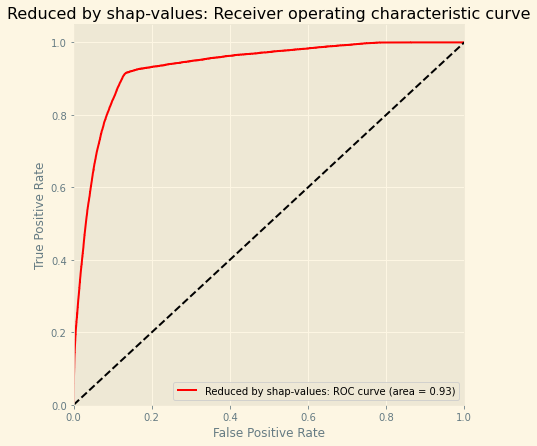

In [337]:
fpr, tpr, roc_thresholds = roc_curve(y_test, test_probs__)
precision, recall, pr_thresholds = precision_recall_curve(y_test, test_probs__)

plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "Reduced by shap-values", color='r')
print("AUC_ROC = %.3f" % auc(fpr, tpr))

AUC_PR = 0.568


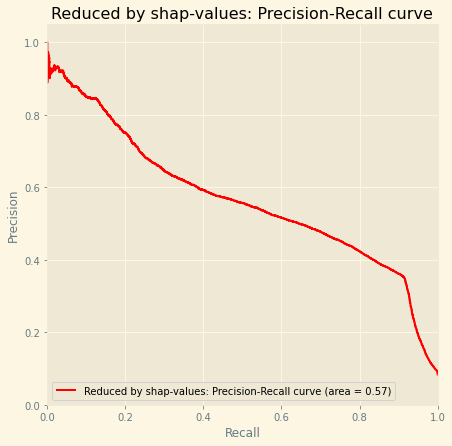

In [338]:
plt.figure(figsize=(7, 7))
    
plot_precision_recall_curve(recall, precision, "Reduced by shap-values", color='r')
print("AUC_PR = %.3f" % auc(recall, precision))

**Statistical features**

In [366]:
X_ = np.concatenate([X_train_, X_test_], axis=0)
y_ = np.concatenate([y_train, y_test], axis=0)

X_ = pd.DataFrame(data=X_, columns=[f'feat_{i+1}' for i in range(X_.shape[1])])

In [367]:
X_ = get_count(X_, X_.columns.tolist())

  0%|          | 0/30 [00:00<?, ?it/s]

In [370]:
X_train_add, X_test_add, y_train_add, y_test_add = train_test_split(X_, y_, shuffle=True, test_size=166330, stratify=y_, 
                                                                    random_state=42)
train_pool_add = Pool(X_train_add, y_train_add)

In [371]:
cat_add = CatBoostClassifier(**total_params).fit(train_pool_add)

test_probs_add = catboost.CatBoost.predict(cat_add, X_test_add, prediction_type='Probability')[:, 1]
train_preds_add = catboost.CatBoost.predict(cat_add, train_pool_add, prediction_type='Class')
test_preds_add = catboost.CatBoost.predict(cat_add, X_test_add, prediction_type='Class')

report(y_train_add, train_preds_add, y_test_add, test_preds_add)

thres, fscore, fmacro = get_best_threshold(y_test_add, test_probs_add)
print(f'Best thres: {thres}, f1-score: {fscore:.4f}, fmacro: {fmacro:.4f}')

Train
               precision    recall  f1-score   support

         0.0     0.9813    0.9239    0.9517    617174
         1.0     0.4426    0.7744    0.5632     48149

    accuracy                         0.9131    665323
   macro avg     0.7119    0.8492    0.7575    665323
weighted avg     0.9423    0.9131    0.9236    665323

Test
               precision    recall  f1-score   support

         0.0     0.9810    0.9242    0.9517    154293
         1.0     0.4420    0.7700    0.5616     12037

    accuracy                         0.9130    166330
   macro avg     0.7115    0.8471    0.7567    166330
weighted avg     0.9420    0.9130    0.9235    166330

Best thres: 0.5634508147171587, f1-score: 0.5678, fmacro: 0.7623


In [372]:
# no improvement
del cat_add, X_train_add, X_test_add, train_pool_add, test_probs_add, train_preds_add, test_preds_add, X_, y_
gc.collect()

7876

**Use full noisy dataset**

In [68]:
# Full dataset
cat = CatBoostClassifier(**total_params).fit(train_pool)

test_probs = catboost.CatBoost.predict(cat, X_test, prediction_type='Probability')[:, 1]
train_preds = catboost.CatBoost.predict(cat, train_pool, prediction_type='Class')
test_preds = catboost.CatBoost.predict(cat, X_test, prediction_type='Class')

report(y_train, train_preds, y_test, test_preds)

thres, fscore, fmacro = get_best_threshold(y_test, test_probs)
print(f'Best thres: {thres}, f1-score: {fscore:.4f}, fmacro: {fmacro:.4f}')

Train
               precision    recall  f1-score   support

         0.0     0.9813    0.9222    0.9508    617174
         1.0     0.4372    0.7743    0.5589     48149

    accuracy                         0.9115    665323
   macro avg     0.7092    0.8483    0.7548    665323
weighted avg     0.9419    0.9115    0.9225    665323

Test
               precision    recall  f1-score   support

         0.0     0.9813    0.9226    0.9510    154293
         1.0     0.4384    0.7749    0.5600     12037

    accuracy                         0.9119    166330
   macro avg     0.7099    0.8488    0.7555    166330
weighted avg     0.9420    0.9119    0.9227    166330

Best thres: 0.576908581841152, f1-score: 0.5669, fmacro: 0.7623


In [69]:
cat.save_model('cat')

In [70]:
cat = CatBoostClassifier()
cat.load_model('cat')

**Data Transformations**

In [90]:
# try data transformations: exp and log lead to occur nans (log(neg. num))
num_cols = X_train.columns[2:-4]
other = [col for col in X_train.columns if col not in num_cols]

X_train_ = pd.concat([X_train, X_train[num_cols].std(axis=1).rename('std'), 
                      X_train[num_cols].mean(axis=1).rename('mean'),
                      X_train[num_cols].sum(axis=1).rename('sum'),
                      X_train[num_cols].max(axis=1).rename('max'),
                      X_train[num_cols].min(axis=1).rename('min')], axis=1)
train_pool_ = Pool(X_train_, y_train, cat_features=cat_cols)
X_test_ = pd.concat([X_test, X_test[num_cols].std(axis=1).rename('std'), 
                     X_test[num_cols].mean(axis=1).rename('mean'),
                     X_test[num_cols].sum(axis=1).rename('sum'),
                     X_test[num_cols].max(axis=1).rename('max'),
                     X_test[num_cols].min(axis=1).rename('min'),
                     ], axis=1)

cat_ = CatBoostClassifier(**total_params).fit(train_pool_)

test_probs_ = catboost.CatBoost.predict(cat_, X_test_, prediction_type='Probability')[:, 1]
train_preds_ = catboost.CatBoost.predict(cat_, train_pool_, prediction_type='Class')
test_preds_ = catboost.CatBoost.predict(cat_, X_test_, prediction_type='Class')

report(y_train, train_preds_, y_test, test_preds_)

thres, fscore, fmacro = get_best_threshold(y_test, test_probs_)
print(f'Best thres: {thres}, f1-score: {fscore:.4f}, fmacro: {fmacro:.4f}')

Train
               precision    recall  f1-score   support

         0.0     0.9813    0.9220    0.9508    617174
         1.0     0.4368    0.7749    0.5586     48149

    accuracy                         0.9114    665323
   macro avg     0.7090    0.8485    0.7547    665323
weighted avg     0.9419    0.9114    0.9224    665323

Test
               precision    recall  f1-score   support

         0.0     0.9813    0.9223    0.9509    154293
         1.0     0.4377    0.7752    0.5595     12037

    accuracy                         0.9117    166330
   macro avg     0.7095    0.8488    0.7552    166330
weighted avg     0.9420    0.9117    0.9226    166330

Best thres: 0.5804547874021947, f1-score: 0.5662, fmacro: 0.7620


In [91]:
# no improvement
del train_pool_, X_train_, X_test_, cat_, test_probs_, train_preds_, test_preds_
gc.collect()

0

**Full sklearn pipeline: from raw test data to final submission**

Quite redundant due to possibilty of predictions by 3 models (trained: full dataset, selected by Shap-values, selected by L1-penalty)

In [381]:
path='data_test.csv'

data = pd.read_csv(path).drop('Unnamed: 0', axis=1)

class Preprocessor(BaseEstimator, TransformerMixin):
    """ 
    takes raw pandas dataframe, containing id, vas_id, buy_time as input
    raw dataframe get merged with features[dataframe.id]
    additional features created
    output - full dataset, ready for train / prediction
    """
    def __init__(self, path='data_test.csv', 
                 features_path='features.pkl', 
                 to_drop=['75', '81', '85', '139', '203'],
                 eliminate_features=None,
                 logreg=True,
                 has_cat=False):  # set to False if model trained with vas_id as float
        self.data = None
        self.path = path
        self.features = pd.read_pickle(features_path).reset_index().drop(to_drop, axis=1)
        self.eliminate_features = eliminate_features
        self.has_cat = has_cat
        self.logreg = logreg
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        self.data = X.copy()
        self.data['buy_time'] = self.data['buy_time'].astype(np.uint32)
        self.data['id'] = self.data['id'].astype(np.uint64)
        self.features = self.features[self.features['id'].isin(self.data['id'].unique())]

        self.data = self.data.sort_index()
        self.data = self.data.sort_values(by='buy_time')
        self.features = self.features.sort_values(by='buy_time')
        
        data_test = pd.merge_asof(self.data, self.features, on='buy_time', by='id', direction='nearest')
        
        map_dict = {float(i): f'{i}' for i in range(100)}
        
        data_test['date'] = pd.to_datetime(data_test['buy_time'], unit='s')

        data_test['day'] = data_test['date'].dt.day
        data_test['week'] = data_test['date'].dt.week
        data_test['month'] = data_test['date'].dt.month
        data_test['dayweek'] = data_test['date'].dt.weekday
        if self.has_cat:
            data_test['vas_id'] = data_test['vas_id'].map(map_dict).astype('category')
        data_test.set_index('id', inplace=True)

        data_test.drop('date', axis=1, inplace=True)
        data_test.fillna(data_test.median(), inplace=True)  # define filling strategy
        if self.eliminate_features is not None:
            if self.logreg:
                data_test = pd.concat([data_test[data_test.columns[2:-4].tolist()].drop(self.eliminate_features, axis=1), 
                                       data_test[other]], axis=1)
            else:
                data_test.drop(self.eliminate_features, axis=1, inplace=True)
        return data_test
    
    def clear_ram(self):
        del self.features, self.data
        gc.collect()

# SimpleImputer strategy = median, most_frequent

class Predictor(BaseEstimator, ClassifierMixin):
    """
    takes pretrained catboost model and pandas dataframe to predict on
    output: pd.DataFrame with id, vas_id, buy_time, predicted target (calculated with threshold), saved to the same dir as input
    if path to the model is None than the pipiline will fit on loaded dataframe
    threshold cat reduced: 0.562386481759898, full: 0.576908581841152, logreg: 0.5754577266802828
    """
    def __init__(self, threshold=0.562386481759898, model_name='cat_reduced', 
                 has_cat=False, raw=False, save=True, **model_params):
        if model_name is None:
            self.is_fitted = False
        else:
            try:
                self.model = CatBoostClassifier()
                self.model.load_model(model_name)
                self.is_fitted = True
            except:
                self.is_fitted = False
        self.threshold = threshold
        self.raw = raw
        self.save = save
        self.has_cat = has_cat
        if model_params is None:
            self.model_params = {
                                 'iterations': 500,
                                 'silent': True,
                                 'one_hot_max_size': 2,
                                 'allow_writing_files': False,
                                 'random_seed': 42,
                                 'auto_class_weights': 'SqrtBalanced',
                                 'task_type': 'GPU',
                                 }
            
    def fit(self, X, y=None):
        assert 'target' in X.columns, f'There is no target variable in given dataset'
        if self.has_cat:
            cat_cols = X.select_dtypes('category').columns.tolist()
        else:
            cat_cols = None
        X, y = X.drop('target', axis=1), X['target']
        train_pool = Pool(X, y, cat_features=cat_cols)
        del X, y
        self.model = CatBoostClassifier(**self.model_params).fit(train_pool)
        del train_pool
        gc.collect()
        self.is_fitted = True
        return self
            
    def predict(self, X):
        X = X.copy()
        preds = self.predict_proba(X)
        preds = (preds >= self.threshold).astype(int)
        if self.raw:
            return preds
        else:
            X.reset_index(inplace=True)
            X['target'] = preds.astype(int)
            if self.save:
                X[['id', 'vas_id', 'buy_time', 'target']].to_csv('predictions.csv', index=False)
            return X[['id', 'vas_id', 'buy_time', 'target']]
    
    def predict_proba(self, X):
        if self.is_fitted:
            return catboost.CatBoost.predict(self.model, X, prediction_type='Probability')[:, 1]
        else:
            raise TypeError(f'Model is not fitted')

In [382]:
pipe = make_pipeline(Preprocessor(eliminate_features=eliminated_features), 
                     Predictor(model_name='cat_logreg'))

In [383]:
output = pipe.predict(data)

In [384]:
output

,id,vas_id,buy_time,pred
0,2905850,5.0,1546808400,0
1,31619,2.0,1546808400,0
2,1427271,6.0,1546808400,1
3,2162521,6.0,1546808400,1
4,1529304,6.0,1546808400,0
...,...,...,...,...
71226,3145392,6.0,1548018000,1
71227,2452188,2.0,1548018000,0
71228,3145390,2.0,1548018000,0
71229,1447357,6.0,1548018000,1


In [385]:
pipe[0].clear_ram()

In [386]:
output.pred.value_counts()

0    59567
1    11664
Name: pred, dtype: int64

## $Luigi$

In [348]:
import luigi

In [456]:
class Transformer(luigi.Task):
    path_data_train = luigi.Parameter()
    path_features = luigi.Parameter()
    to_drop = ['75', '81', '85', '139', '203',] 
    eliminate = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
                 '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '27', '28', '29', '30', '31', 
                 '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46',
                 '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '62', '63', '64', '65', '66', '67', 
                 '68', '69', '70', '71',  '72', '73', '74', '76', '77', '78', '79', '80', '82', '83', '84',
                 '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', 
                 '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '116', '117',
                 '118', '119', '120', '121', '122', '123', '124', '125', '127', '129', '130', '133', '134', '135', '136', 
                 '137', '138', '140', '141', '142', '143', '144', '146', '147', '149', '150', '151',
                 '152', '153', '154', '155', '156', '157', '158', '161', '162', '163', '164', '165', '166', '167', '168', 
                 '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180',
                 '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '197', '199', '200', '201', 
                 '202', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216',
                 '217', '218', '219', '220', '221', '222', '223', '226', '227', '228', '229', '230', '231', '232', '233', 
                 '234', '235', '236', '237', '238', '239', '240', '241', '242', '243', '244', '245',
                 '246', '247', '248', '249', '250', '251', '252']
    other = ['vas_id', 'buy_time', 'day', 'week', 'month', 'dayweek']
    
    def output(self):
        return luigi.LocalTarget('prepared_data_test.csv')
    
    def _prepare(self, data, features):
        data = data.copy()
        data['buy_time'] = data['buy_time'].astype(np.uint32)
        data['id'] = data['id'].astype(np.uint64)
        features = features[features['id'].isin(data['id'].unique())]

        data = data.sort_index()
        data = data.sort_values(by='buy_time')
        features = features.sort_values(by='buy_time')
        
        data_test = pd.merge_asof(data, features, on='buy_time', by='id', direction='nearest')
                
        data_test['date'] = pd.to_datetime(data_test['buy_time'], unit='s')

        data_test['day'] = data_test['date'].dt.day
        data_test['week'] = data_test['date'].dt.week
        data_test['month'] = data_test['date'].dt.month
        data_test['dayweek'] = data_test['date'].dt.weekday

        data_test.set_index('id', inplace=True)

        data_test.drop('date', axis=1, inplace=True)
        data_test.fillna(data_test.median(), inplace=True)
        
        data_test = pd.concat([data_test[data_test.columns[2:-4].tolist()].drop(self.eliminate, axis=1), 
                               data_test[other]], axis=1)
        
        return data_test
    
    def run(self):
        df = pd.read_csv(self.path_data_train).drop('Unnamed: 0', axis=1)
        features = pd.read_pickle(self.path_features).reset_index().drop(self.to_drop, axis=1)
        df = self._prepare(df, features)
        del features

        with self.output().open('w') as f:
            f.write(df.to_csv(index=True, encoding='utf-8'))
        gc.collect()

class Forecater(luigi.Task):
    path_data_train = luigi.Parameter()
    path_features = luigi.Parameter()
    
    def output(self):
        return luigi.LocalTarget('luigi_predictions.csv')
    
    def requires(self):
        return Transformer(self.path_data_train, self.path_features)
    
    def run(self):
        df = pd.read_csv(self.input().open('r'), index_col='id')
        model = CatBoostClassifier().load_model('cat_logreg')
        
        probas = catboost.CatBoost.predict(model, df, prediction_type='Probability')[:, 1]
        preds = (probas >= 0.5754577266802828).astype(int)
        df['target'] = preds
        df.reset_index(inplace=True)
        
        with self.output().open('w') as f:
            f.write(df[['id', 'vas_id', 'buy_time', 'target']].to_csv(index=False, encoding='utf8'))

In [457]:
if __name__ == '__main__':
    luigi.build([Forecater('data_test.csv', 'features.pkl')])

DEBUG: Checking if Forecater(path_data_train=data_test.csv, path_features=features.pkl) is complete
DEBUG: Checking if Transformer(path_data_train=data_test.csv, path_features=features.pkl) is complete
INFO: Informed scheduler that task   Forecater_data_test_csv_features_pkl_8c6c32ee54   has status   PENDING
INFO: Informed scheduler that task   Transformer_data_test_csv_features_pkl_8c6c32ee54   has status   PENDING
INFO: Done scheduling tasks
INFO: Running Worker with 1 processes
DEBUG: Asking scheduler for work...
DEBUG: Pending tasks: 2
INFO: [pid 4152] Worker Worker(salt=837565969, workers=1, host=LAPTOP-0V1S84ED, username=Daria, pid=4152) running   Transformer(path_data_train=data_test.csv, path_features=features.pkl)
INFO: [pid 4152] Worker Worker(salt=837565969, workers=1, host=LAPTOP-0V1S84ED, username=Daria, pid=4152) done      Transformer(path_data_train=data_test.csv, path_features=features.pkl)
DEBUG: 1 running tasks, waiting for next task to finish
INFO: Informed scheduler